In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [4]:
notebook = "real2_WineQuality"

In [5]:
import numpy as np

from ucimlrepo import fetch_ucirepo 

winequality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = winequality.data.features
y = winequality.data.targets

In [6]:
X = X.values.astype(float)
y = np.array(y).astype(np.float32).reshape(-1)

In [7]:
ndpost = 10000
nskip = 0
n_trees = 100

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
proposal_probs_default = {
    'grow': 0.25,
    'prune': 0.25,
    'change': 0.4,
    'swap': 0.1
}
bart = DefaultBART(ndpost=ndpost, nskip=nskip, n_trees=n_trees,
                proposal_probs=proposal_probs_default, random_state=0)
bart.fit(X_train, y_train)
sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
preds = bart.posterior_f(X_test, backtransform=True)
rmses = [root_mean_squared_error(y_test, preds[:, k]) for k in range(preds.shape[1])]

np.save(f'store/{notebook}_sigmas_default.npy', np.array(sigmas))
np.save(f'store/{notebook}_rmses_default.npy', np.array(rmses))

Iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

Iterations: 100%|██████████| 10000/10000 [03:00<00:00, 55.25it/s]


In [10]:
proposal_probs_mtmh = {
    'multi_grow': 0.25,
    'multi_prune': 0.25,
    'multi_change': 0.4,
    'multi_swap': 0.1
}
bart = MultiBART(ndpost=ndpost, nskip=nskip, n_trees=n_trees,
                proposal_probs=proposal_probs_mtmh, multi_tries=10, random_state=0)
bart.fit(X_train, y_train)
sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
preds = bart.posterior_f(X_test, backtransform=True)
rmses = [root_mean_squared_error(y_test, preds[:, k]) for k in range(preds.shape[1])]

np.save(f'store/{notebook}_sigmas_mtmh.npy', np.array(sigmas))
np.save(f'store/{notebook}_rmses_mtmh.npy', np.array(rmses))

Iterations: 100%|██████████| 10000/10000 [22:02<00:00,  7.56it/s]


In [11]:
from diagnosis import segmented_ljung_box_test, segment_ess_efficiency

## Default

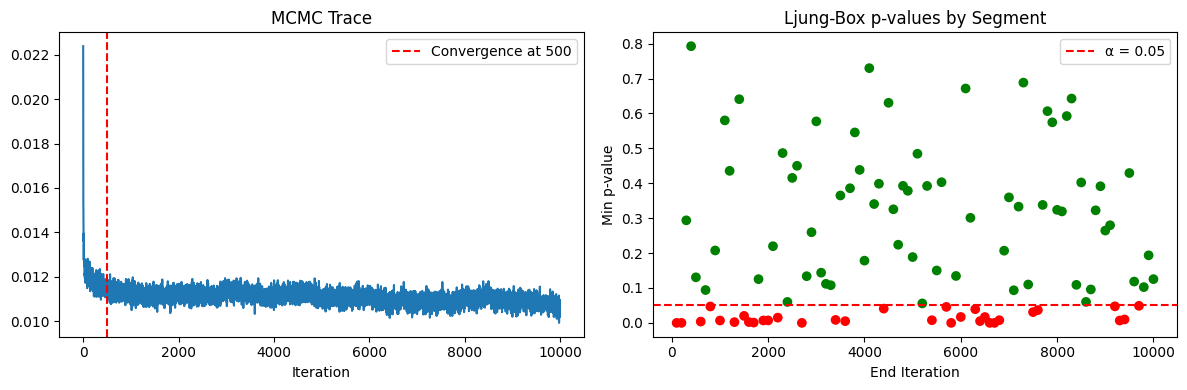

Chain converged: True
Convergence at iteration: 500
Convergence rate: 68.00%


In [12]:
# Diagnose default sigma convergence
sigmas = np.load(f'store/{notebook}_sigmas_default.npy')
convergence_result = segmented_ljung_box_test(sigmas, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

/nfs/home/svu/e0950116/bart-playground/diagnosis/diagnosis.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


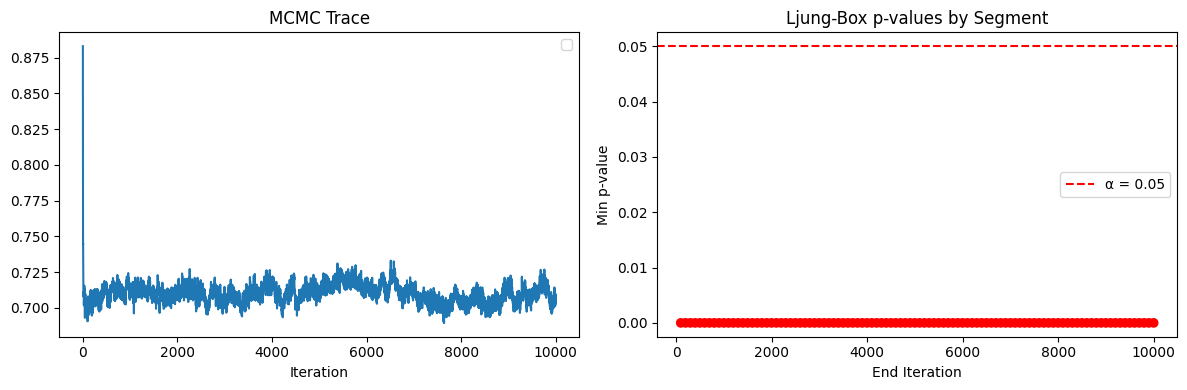

Chain converged: False
Convergence rate: 0.00%


In [13]:
# Diagnose default rmse convergence
rmses = np.load(f'store/{notebook}_rmses_default.npy')
convergence_result = segmented_ljung_box_test(rmses, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

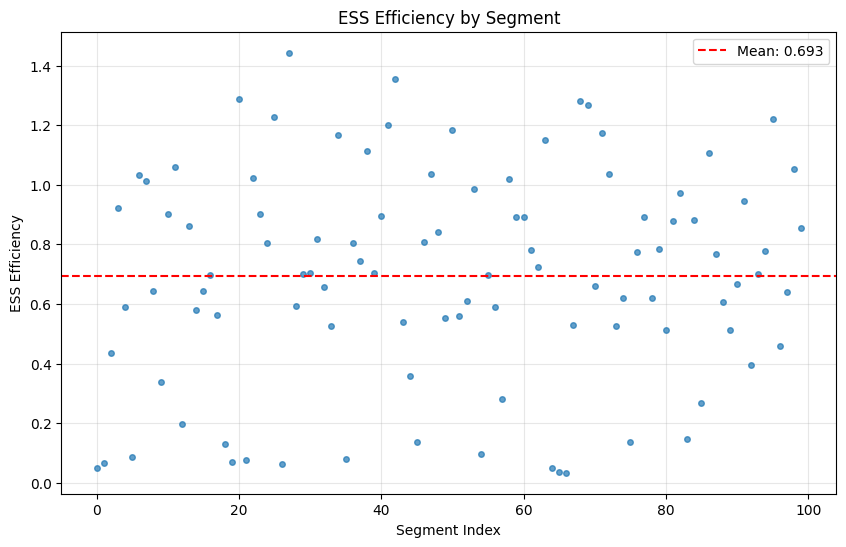

In [14]:
sigmas = np.load(f'store/{notebook}_sigmas_default.npy')
efficiencies = segment_ess_efficiency(sigmas, segment_length=100)

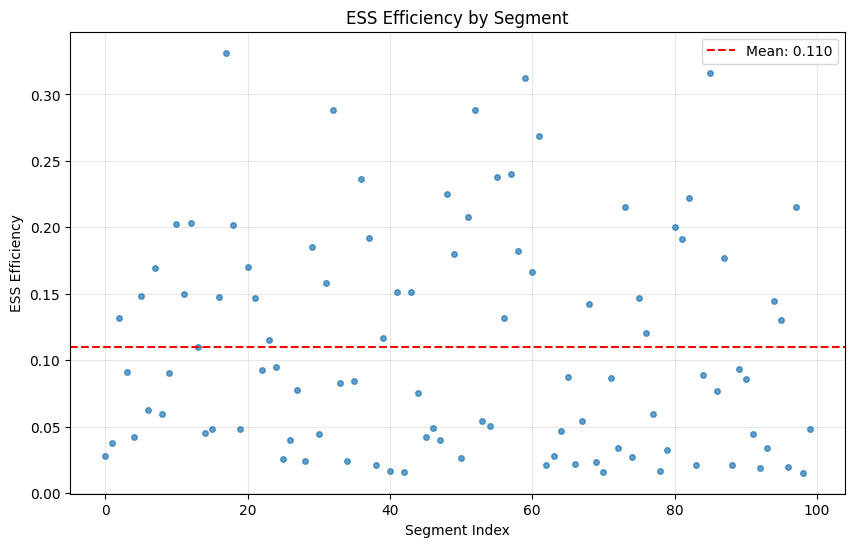

In [15]:
rmses = np.load(f'store/{notebook}_rmses_default.npy')
efficiencies = segment_ess_efficiency(rmses, segment_length=100)

### Autocorrelation

In [9]:
from diagnosis import plot_autocorrelation

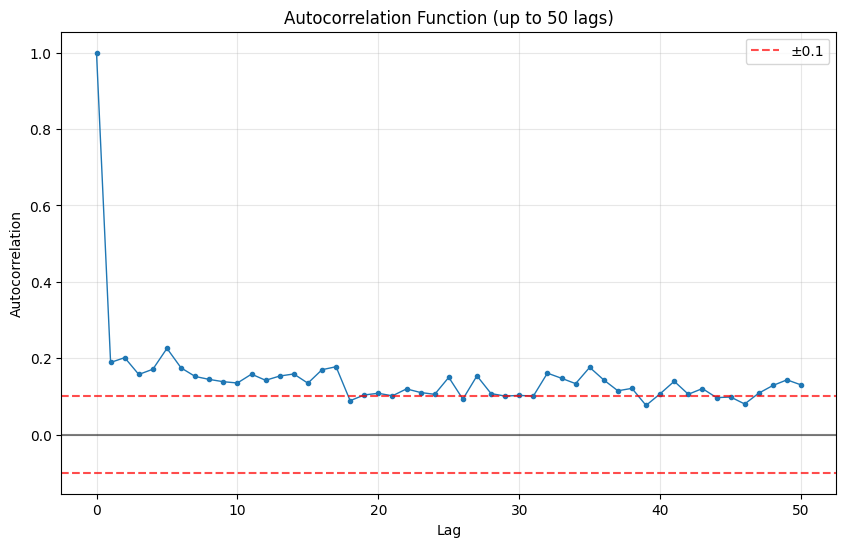

array([1.        , 0.18876422, 0.20139988, 0.15739251, 0.17106491,
       0.22569189, 0.17464198, 0.15214256, 0.14437135, 0.13836095,
       0.13499727, 0.1581612 , 0.14206905, 0.15321094, 0.15864884,
       0.13448759, 0.16971802, 0.17763248, 0.08867526, 0.10365896,
       0.1080717 , 0.10135976, 0.11954732, 0.11004585, 0.10532949,
       0.14982793, 0.09273185, 0.15371945, 0.10728876, 0.10071302,
       0.10254043, 0.10069561, 0.16084747, 0.14739333, 0.13330842,
       0.17597936, 0.14297201, 0.11462455, 0.12096438, 0.07626568,
       0.1067818 , 0.13946013, 0.10550544, 0.12039296, 0.09664787,
       0.09826409, 0.07999716, 0.10842227, 0.12844601, 0.14324265,
       0.12999946])

In [10]:
sigmas = np.load(f'store/{notebook}_sigmas_default.npy')
plot_autocorrelation(sigmas[-1000:], nlags=50)

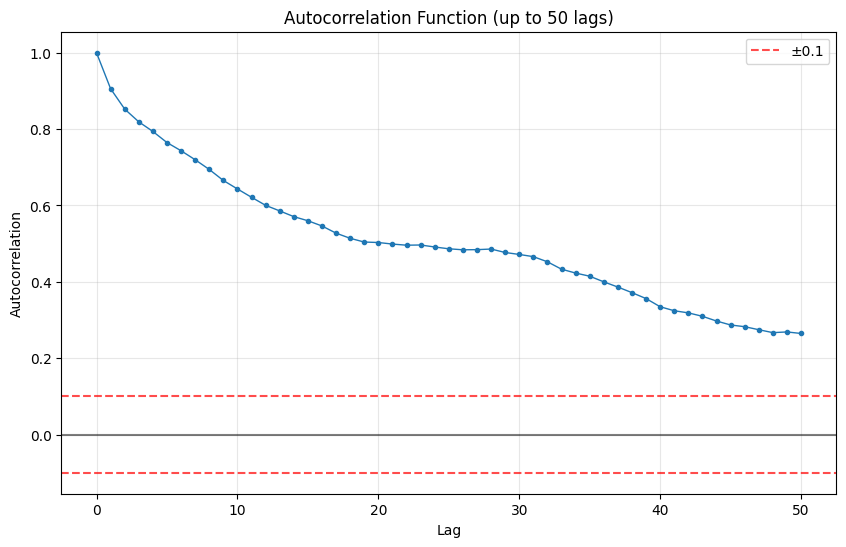

array([1.        , 0.9057377 , 0.85240182, 0.81898702, 0.79379922,
       0.7647342 , 0.7432857 , 0.71975892, 0.69432239, 0.66547272,
       0.64325591, 0.62143338, 0.60031431, 0.58570463, 0.57072977,
       0.55994658, 0.5462568 , 0.52747135, 0.51396725, 0.50414814,
       0.50294017, 0.49888568, 0.49588831, 0.49642374, 0.49120851,
       0.48648702, 0.48385753, 0.48424476, 0.48581374, 0.47682867,
       0.4716499 , 0.4659258 , 0.45241119, 0.43309661, 0.42291131,
       0.4146866 , 0.39992262, 0.38626427, 0.37164486, 0.35610746,
       0.33472091, 0.32420611, 0.31865969, 0.30969703, 0.29730796,
       0.28695173, 0.28244997, 0.27455652, 0.26687471, 0.26870332,
       0.2647216 ])

In [11]:
rmses = np.load(f'store/{notebook}_rmses_default.npy')
plot_autocorrelation(rmses[-1000:], nlags=50)

## MTMH

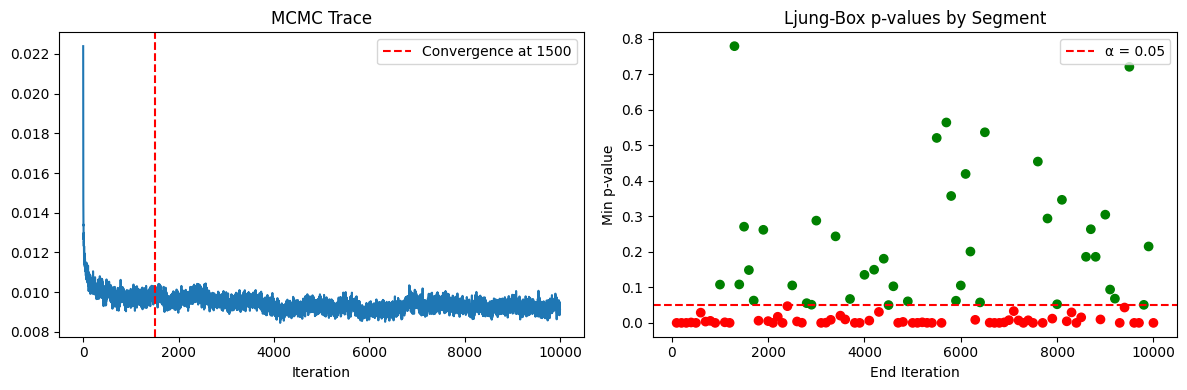

Chain converged: True
Convergence at iteration: 1500
Convergence rate: 41.00%


In [16]:
# Diagnose mtmh sigma convergence
sigmas = np.load(f'store/{notebook}_sigmas_mtmh.npy')
convergence_result = segmented_ljung_box_test(sigmas, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

/nfs/home/svu/e0950116/bart-playground/diagnosis/diagnosis.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


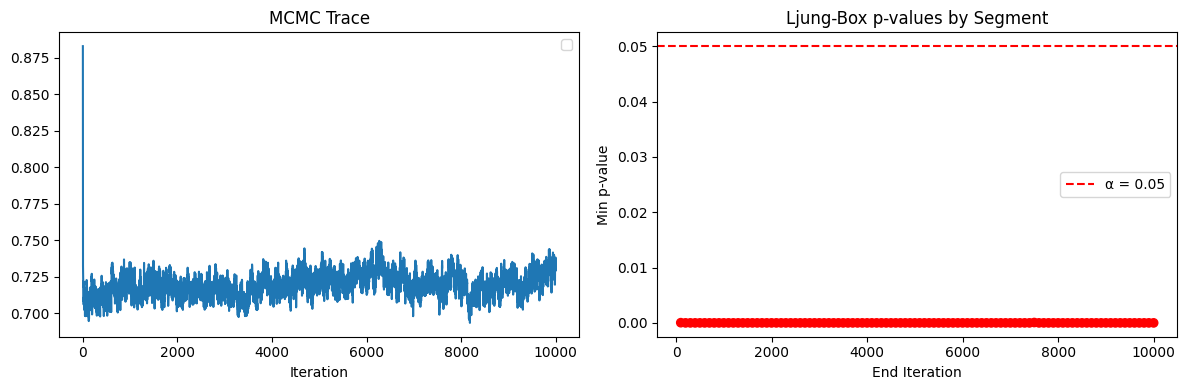

Chain converged: False
Convergence rate: 0.00%


In [17]:
# Diagnose mtmh rmse convergence
rmses = np.load(f'store/{notebook}_rmses_mtmh.npy')
convergence_result = segmented_ljung_box_test(rmses, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

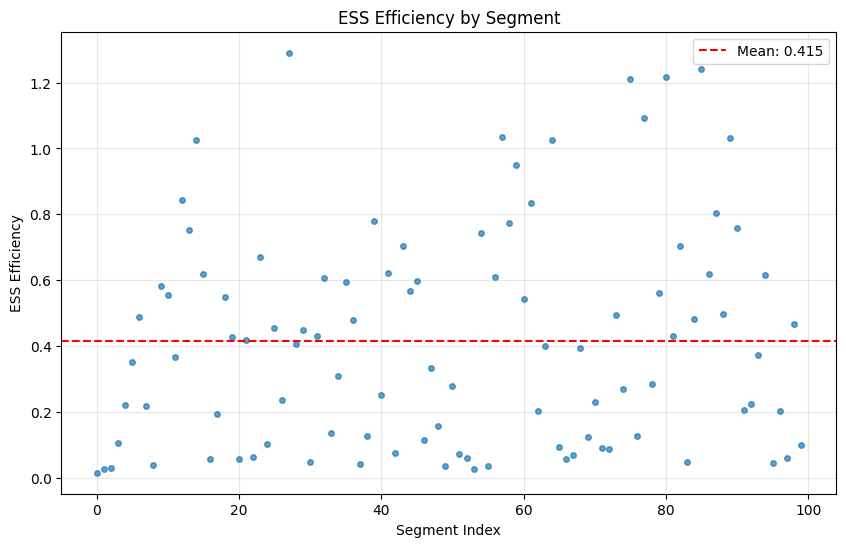

In [18]:
sigmas = np.load(f'store/{notebook}_sigmas_mtmh.npy')
efficiencies = segment_ess_efficiency(sigmas, segment_length=100)

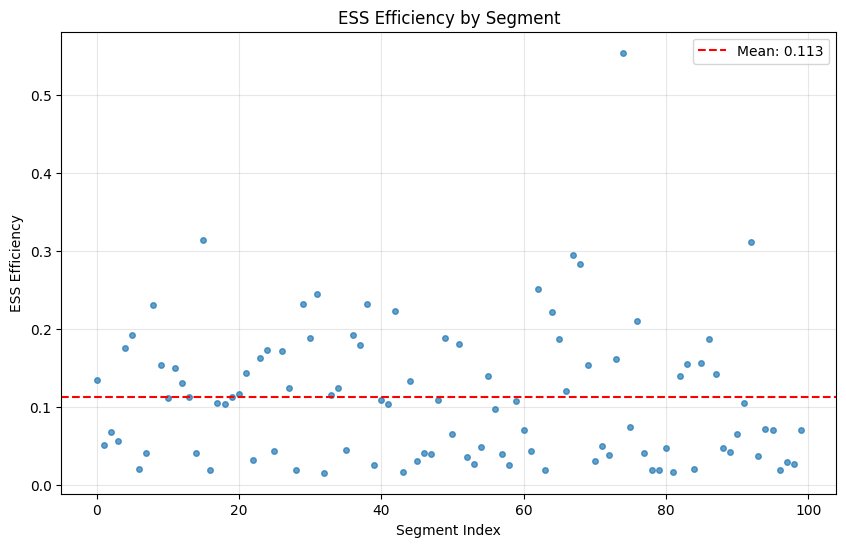

In [19]:
rmses = np.load(f'store/{notebook}_rmses_mtmh.npy')
efficiencies = segment_ess_efficiency(rmses, segment_length=100)

### Autocorrelation

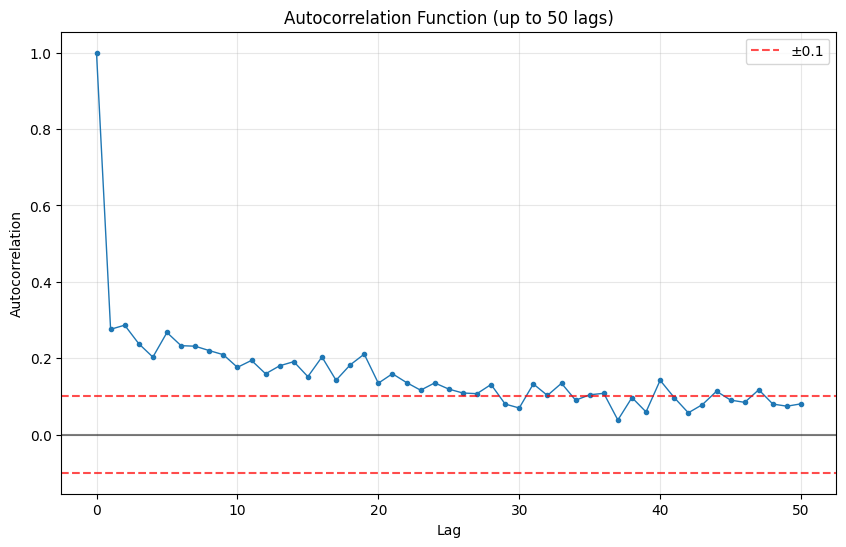

array([1.        , 0.27562874, 0.28645325, 0.23787171, 0.2028345 ,
       0.2672951 , 0.23276203, 0.23136924, 0.21989342, 0.20913339,
       0.17601091, 0.19417623, 0.159126  , 0.18010506, 0.19089078,
       0.15161445, 0.20316093, 0.14221324, 0.18231015, 0.21063497,
       0.13445699, 0.15923052, 0.13621244, 0.11613557, 0.13522798,
       0.11901755, 0.10877147, 0.10705555, 0.1310383 , 0.07988284,
       0.06952165, 0.13251872, 0.10240835, 0.13430605, 0.08987346,
       0.1041017 , 0.10798106, 0.03799229, 0.09684153, 0.05920416,
       0.14206896, 0.09678873, 0.05691511, 0.07844265, 0.11336161,
       0.09016477, 0.08431129, 0.11727566, 0.07978827, 0.07423644,
       0.08043136])

In [12]:
sigmas = np.load(f'store/{notebook}_sigmas_mtmh.npy')
plot_autocorrelation(sigmas[-1000:], nlags=50)

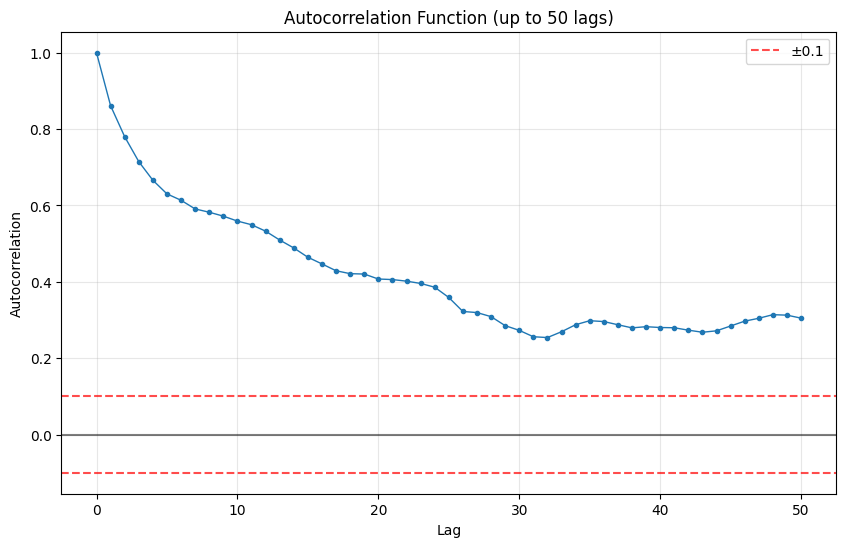

array([1.        , 0.86121536, 0.77998704, 0.71478697, 0.66599113,
       0.63030501, 0.61356242, 0.59086643, 0.58223112, 0.57198286,
       0.55909225, 0.54950793, 0.53266725, 0.50945392, 0.48866843,
       0.4643388 , 0.44685114, 0.42898839, 0.42134218, 0.42033151,
       0.40732748, 0.40588465, 0.40171749, 0.39575511, 0.38587181,
       0.35899757, 0.3223238 , 0.31945008, 0.30877821, 0.285245  ,
       0.27290711, 0.25616466, 0.25398625, 0.26925563, 0.2876049 ,
       0.29812405, 0.29591903, 0.2875556 , 0.27939582, 0.2824469 ,
       0.28033005, 0.27967028, 0.27335929, 0.26791424, 0.27162353,
       0.284267  , 0.29695803, 0.30450541, 0.31391978, 0.31268698,
       0.30488533])

In [13]:
rmses = np.load(f'store/{notebook}_rmses_mtmh.npy')
plot_autocorrelation(rmses[-1000:], nlags=50)